 # Grid Search for Ternary Classification



 This notebook performs grid search optimization for the ternary classification model.

 It searches over:



 1. **Labeling parameters**: horizon, gauss_window, gauss_std

 2. **Feature parameters**: orb_multiplier, coord_mode (geo/helio/both)

 3. **Model hyperparameters**: max_depth, learning_rate, weight_power



 Uses caching to avoid recomputation of intermediate data.

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════════
# ENVIRONMENT CHECK & PATH SETUP
# ═══════════════════════════════════════════════════════════════════════════════════
# We need to find the project root directory and add it to Python's path.
# This allows us to import our custom RESEARCH modules from anywhere.
# ═══════════════════════════════════════════════════════════════════════════════════

import sys
from pathlib import Path

# Find project root by looking for RESEARCH folder
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Python: {sys.version}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")


Python: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:25:55) [GCC 14.3.0]
PROJECT_ROOT: /home/rut/ostrofun


 ## 1. Setup & Configuration

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════════
# IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════════
import itertools
import time
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any, Optional

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# RESEARCH modules
from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data
from RESEARCH.labeling import create_ternary_labels
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates_multi,
    calculate_aspects_for_dates,
    calculate_phases_for_dates,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    calc_metrics,
    check_cuda_available,
    compute_stronger_weights,
)
from RESEARCH.cache_utils import (
    save_cache,
    load_cache,
    cache_exists,
    list_cache,
    get_cache_path,
)

print("✓ All modules imported")


/mnt/w/WSL/btc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All modules imported


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════════
# GRID SEARCH CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════════════
# Define all parameter grids to search over.
# Keep grids small for initial exploration, expand later.
# ═══════════════════════════════════════════════════════════════════════════════════

# ─────────────────────────────────────────────────────────────────────────────────
# DATA PARAMETERS (fixed for this search)
# ─────────────────────────────────────────────────────────────────────────────────
DATA_START = "2017-11-01"  # Bitcoin price history start

# ─────────────────────────────────────────────────────────────────────────────────
# LABELING PARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
# horizon: How many days ahead we're predicting
# gauss_window: Size of Gaussian smoothing window (must be odd)
# gauss_std: Standard deviation of Gaussian
LABEL_GRID = {
    "horizon": [1,],            # 1, 3, or 5 days ahead
    "gauss_window": [101, 201, 301], # Smoothing window sizes
    "gauss_std": [25.0, 50.0, 100.0], # Gaussian std
}

# ─────────────────────────────────────────────────────────────────────────────────
# FEATURE PARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
# coord_mode: 'geo' (Earth-centered), 'helio' (Sun-centered), or 'both'
# orb_multiplier: Scale for aspect orbs (lower = stricter)
FEATURE_GRID = {
    "coord_mode": ["geo", "helio",  "both"],           # Start with both geo+helio
    "orb_multiplier": [0.1,0.15,0.25,0.5], # Aspect orb scaling
    "include_phases": [True],          # Always include moon phases
}

# ─────────────────────────────────────────────────────────────────────────────────
# MODEL HYPERPARAMETERS GRID
# ─────────────────────────────────────────────────────────────────────────────────
MODEL_GRID = {
    "max_depth": [3, 5,9],           # Tree depth
    "learning_rate": [0.01, 0.03, 0.05], # Step size
    "weight_power": [1.5, 2.0, 2.5],  # Minority class amplification
    "n_estimators": [500],            # Fixed number of trees
    "subsample": [0.8],               # Fixed
    "colsample_bytree": [0.8],        # Fixed
}

# ─────────────────────────────────────────────────────────────────────────────────
# SEARCH SETTINGS
# ─────────────────────────────────────────────────────────────────────────────────
# Set to True for quick test run with reduced grid
TEST_MODE = True  # Set to False for full search

if TEST_MODE:
    print("⚠️ TEST MODE: Using reduced grid for quick testing")
    LABEL_GRID = {
        "horizon": [1],
        "gauss_window": [201],
        "gauss_std": [50.0],
    }
    FEATURE_GRID = {
        "coord_mode": ["both"],
        "orb_multiplier": [1.0],
        "include_phases": [True],
    }
    MODEL_GRID = {
        "max_depth": [4],
        "learning_rate": [0.03],
        "weight_power": [1.5, 2.0],
        "n_estimators": [300],
        "subsample": [0.8],
        "colsample_bytree": [0.8],
    }


⚠️ TEST MODE: Using reduced grid for quick testing


In [4]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CALCULATE TOTAL COMBINATIONS
# ═══════════════════════════════════════════════════════════════════════════════════

def count_combinations(grid: Dict[str, List]) -> int:
    """Count total combinations in a parameter grid."""
    total = 1
    for values in grid.values():
        total *= len(values)
    return total

label_combos = count_combinations(LABEL_GRID)
feature_combos = count_combinations(FEATURE_GRID)
model_combos = count_combinations(MODEL_GRID)
total_combos = label_combos * feature_combos * model_combos

print(f"\nGrid Search Statistics:")
print(f"  Label combinations:   {label_combos}")
print(f"  Feature combinations: {feature_combos}")
print(f"  Model combinations:   {model_combos}")
print(f"  ─────────────────────────────")
print(f"  TOTAL COMBINATIONS:   {total_combos}")



Grid Search Statistics:
  Label combinations:   1
  Feature combinations: 1
  Model combinations:   2
  ─────────────────────────────
  TOTAL COMBINATIONS:   2


 ## 2. Load Market Data

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════════
# LOAD MARKET DATA (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════

MARKET_CACHE_PARAMS = {
    "subject_id": cfg.active_subject_id,
    "start_date": DATA_START,
}

df_market = load_cache("market", "data", MARKET_CACHE_PARAMS, verbose=True)

if df_market is None:
    print("Loading from database...")
    df_market = load_market_data()
    df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)
    save_cache(df_market, "market", "data", MARKET_CACHE_PARAMS)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")


📂 Loading from cache: market__data__btc_2017-11-01__8d63944e.parquet

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


 ## 3. Initialize Ephemeris

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════════
# INITIALIZE ASTRO SETTINGS
# ═══════════════════════════════════════════════════════════════════════════════════

settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")

# Check CUDA availability
use_cuda, device = check_cuda_available()
print(f"Device: {device}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Device: cuda


 ## 4. Grid Search Functions

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════════
# GRID SEARCH HELPER FUNCTIONS
# ═══════════════════════════════════════════════════════════════════════════════════

def generate_grid_combinations(grid: Dict[str, List]) -> List[Dict[str, Any]]:
    """
    Generate all combinations of parameter values from a grid.
    
    Args:
        grid: Dictionary of parameter_name -> list of values
    
    Returns:
        List of dictionaries, each containing one combination
    
    Example:
        grid = {"a": [1, 2], "b": ["x", "y"]}
        result = [{"a": 1, "b": "x"}, {"a": 1, "b": "y"}, ...]
    """
    keys = list(grid.keys())
    values = list(grid.values())
    
    combinations = []
    for combo in itertools.product(*values):
        combinations.append(dict(zip(keys, combo)))
    
    return combinations


def get_or_compute_labels(
    df_market: pd.DataFrame,
    label_params: Dict,
) -> pd.DataFrame:
    """
    Get labels from cache or compute them.
    
    This is the first step where caching saves the most time,
    since label computation involves detrending which is slow.
    """
    cache_params = {
        "subject_id": cfg.active_subject_id,
        "start_date": DATA_START,
        "type": "ternary",
        **label_params,
    }
    
    # Try cache
    df_labels = load_cache("labels", "ternary", cache_params, verbose=False)
    
    if df_labels is None:
        # Compute
        df_labels, threshold = create_ternary_labels(
            df_market,
            horizon=label_params["horizon"],
            gauss_window=label_params["gauss_window"],
            gauss_std=label_params["gauss_std"],
            balance_classes=True,
            verbose=False,
        )
        save_cache(df_labels, "labels", "ternary", cache_params, verbose=False)
    
    return df_labels


def get_or_compute_features(
    df_market: pd.DataFrame,
    settings,
    feature_params: Dict,
) -> pd.DataFrame:
    """
    Get features from cache or compute them.
    
    Features are the most expensive to compute (bodies + aspects + phases).
    Caching here saves significant time in grid search.
    """
    date_range = f"{df_market['date'].min().date()}_{df_market['date'].max().date()}"
    
    cache_params = {
        "coord_mode": feature_params["coord_mode"],
        "orb_mult": feature_params["orb_multiplier"],
        "include_phases": feature_params["include_phases"],
        "date_range": date_range,
    }
    
    # Try cache for complete feature set
    df_features = load_cache("features", "ternary", cache_params, verbose=False)
    
    if df_features is None:
        # ─────────────────────────────────────────────────────────────────────────
        # Compute bodies (most time-consuming)
        # ─────────────────────────────────────────────────────────────────────────
        bodies_cache_params = {
            "coord_mode": feature_params["coord_mode"],
            "date_range": date_range,
        }
        
        df_bodies = load_cache("astro", "bodies", bodies_cache_params, verbose=False)
        geo_by_date = load_cache("astro", "bodies_geo_dict", bodies_cache_params, verbose=False)
        helio_by_date = load_cache("astro", "bodies_helio_dict", bodies_cache_params, verbose=False)
        
        # If bodies not cached, compute them
        if df_bodies is None:
            df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
                df_market["date"],
                settings,
                coord_mode=feature_params["coord_mode"],
                progress=False,
            )
            save_cache(df_bodies, "astro", "bodies", bodies_cache_params, verbose=False)
            save_cache(geo_by_date, "astro", "bodies_geo_dict", bodies_cache_params, verbose=False)
            if helio_by_date:
                save_cache(helio_by_date, "astro", "bodies_helio_dict", bodies_cache_params, verbose=False)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Compute aspects (needs geo_by_date)
        # ─────────────────────────────────────────────────────────────────────────
        aspects_cache_params = {
            "orb_mult": feature_params["orb_multiplier"],
            "coord_mode": feature_params["coord_mode"],
            "date_range": date_range,
        }
        
        df_aspects = load_cache("astro", "aspects", aspects_cache_params, verbose=False)
        
        # Only compute if not cached AND we have geo_by_date
        if df_aspects is None:
            if geo_by_date is not None:
                df_aspects = calculate_aspects_for_dates(
                    geo_by_date,
                    settings,
                    orb_mult=feature_params["orb_multiplier"],
                    progress=False,
                )
                save_cache(df_aspects, "astro", "aspects", aspects_cache_params, verbose=False)
            else:
                # Create empty aspects DataFrame if geo_by_date not available
                df_aspects = pd.DataFrame(columns=["date"])
        
        # ─────────────────────────────────────────────────────────────────────────
        # Compute phases
        # ─────────────────────────────────────────────────────────────────────────
        phases_cache_params = {"date_range": date_range}
        
        df_phases = None
        if feature_params["include_phases"]:
            df_phases = load_cache("astro", "phases", phases_cache_params, verbose=False)
            
            if df_phases is None and geo_by_date is not None:
                df_phases = calculate_phases_for_dates(geo_by_date, progress=False)
                save_cache(df_phases, "astro", "phases", phases_cache_params, verbose=False)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Build feature matrix
        # ─────────────────────────────────────────────────────────────────────────
        df_features = build_full_features(
            df_bodies,
            df_aspects,
            df_phases=df_phases,
            include_pair_aspects=True,
        )
        
        save_cache(df_features, "features", "ternary", cache_params, verbose=False)
    
    return df_features


def run_single_experiment(
    df_dataset: pd.DataFrame,
    model_params: Dict,
    device: str,
) -> Dict:
    """
    Run a single training experiment with given parameters.
    
    Returns metrics on test set.
    """
    # ─────────────────────────────────────────────────────────────────────────────
    # Split data
    # ─────────────────────────────────────────────────────────────────────────────
    train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)
    
    feature_cols = get_feature_columns(df_dataset)
    X_train, y_train = prepare_xy(train_df, feature_cols)
    X_val, y_val = prepare_xy(val_df, feature_cols)
    X_test, y_test = prepare_xy(test_df, feature_cols)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Extract weight_power from model_params
    # ─────────────────────────────────────────────────────────────────────────────
    weight_power = model_params.pop("weight_power", 2.0)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Train model
    # ─────────────────────────────────────────────────────────────────────────────
    model = train_xgb_model(
        X_train, y_train,
        X_val, y_val,
        feature_cols,
        n_classes=3,
        device=device,
        weight_power=weight_power,
        verbose=False,
        **model_params,
    )
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Evaluate on test set
    # ─────────────────────────────────────────────────────────────────────────────
    X_test_scaled = model.scaler.transform(X_test)
    y_proba = model.model.predict_proba(X_test_scaled)
    y_pred = y_proba.argmax(axis=1)
    
    metrics = calc_metrics(y_test, y_pred, labels=[0, 1, 2])
    
    # Add weight_power back for logging
    model_params["weight_power"] = weight_power
    
    return metrics



In [8]:
# ═══════════════════════════════════════════════════════════════════════════════════
# EVALUATION & VISUALIZATION FUNCTION
# ═══════════════════════════════════════════════════════════════════════════════════
# This function can be called:
#   - BEFORE grid search as baseline
#   - AFTER grid search with best model
# ═══════════════════════════════════════════════════════════════════════════════════

def evaluate_and_visualize_model(
    model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    df_test: pd.DataFrame,
    title: str = "Model Evaluation",
) -> Dict:
    """
    ═══════════════════════════════════════════════════════════════════════════════
    COMPREHENSIVE MODEL EVALUATION WITH VISUALIZATIONS
    ═══════════════════════════════════════════════════════════════════════════════
    
    Displays:
    1. All metrics (accuracy, balanced accuracy, MCC, F1, per-class recalls)
    2. Confusion matrix heatmap
    3. Two price charts with class labels:
       - Top: TRUE labels (from data)
       - Bottom: PREDICTED labels (from model)
    
    Args:
        model: Trained XGBBaseline model
        X_test: Test features (NOT scaled)
        y_test: True labels
        df_test: Test DataFrame with 'date' and 'close' columns
        title: Title for the evaluation
    
    Returns:
        Dictionary with all metrics
    ═══════════════════════════════════════════════════════════════════════════════
    """
    # ─────────────────────────────────────────────────────────────────────────────
    # Get predictions
    # ─────────────────────────────────────────────────────────────────────────────
    X_test_scaled = model.scaler.transform(X_test)
    y_proba = model.model.predict_proba(X_test_scaled)
    y_pred = y_proba.argmax(axis=1)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Calculate metrics
    # ─────────────────────────────────────────────────────────────────────────────
    metrics = calc_metrics(y_test, y_pred, labels=[0, 1, 2])
    
    CLASS_NAMES = ["DOWN", "SIDEWAYS", "UP"]
    
    print("\n" + "=" * 80)
    print(f"  {title}")
    print("=" * 80)
    
    print("\n📊 METRICS:")
    print(f"  Accuracy:          {metrics['acc']:.4f}")
    print(f"  Balanced Accuracy: {metrics['bal_acc']:.4f}")
    print(f"  MCC:               {metrics['mcc']:.4f}")
    print(f"  F1 Macro:          {metrics['f1_macro']:.4f}")
    
    print("\n📈 PER-CLASS RECALL:")
    print(f"  DOWN (0):     {metrics['recall_down']:.4f}")
    
    # Calculate SIDEWAYS recall manually
    mask_sideways = (y_test == 1)
    recall_sideways = (y_pred[mask_sideways] == 1).sum() / mask_sideways.sum() if mask_sideways.sum() > 0 else 0
    print(f"  SIDEWAYS (1): {recall_sideways:.4f}")
    print(f"  UP (2):       {metrics['recall_up']:.4f}")
    
    print(f"\n🎯 RECALL MIN:  {metrics['recall_min']:.4f} (quality)")
    print(f"   RECALL GAP:  {metrics['recall_gap']:.4f} (balance)")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Classification report
    # ─────────────────────────────────────────────────────────────────────────────
    print("\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Create figure with 3 subplots
    # ─────────────────────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 1: Confusion Matrix
    # ─────────────────────────────────────────────────────────────────────────────
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].set_title(f"Confusion Matrix | Bal.Acc={metrics['bal_acc']:.3f}, Recall MIN={metrics['recall_min']:.3f}")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 2: Price with TRUE labels
    # ─────────────────────────────────────────────────────────────────────────────
    dates = df_test["date"].values
    prices = df_test["close"].values
    
    # Color mapping: DOWN=red, SIDEWAYS=gray, UP=green
    COLORS = {0: "#ff6b6b", 1: "#aaaaaa", 2: "#51cf66"}
    
    ax = axes[1]
    ax.plot(dates, prices, color="black", linewidth=1, alpha=0.8)
    
    # Fill background with true class colors
    for i in range(len(dates) - 1):
        ax.axvspan(dates[i], dates[i+1], alpha=0.3, color=COLORS[y_test[i]], linewidth=0)
    
    ax.set_title("TRUE Labels (Ground Truth)")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS[0], alpha=0.5, label="DOWN"),
        Patch(facecolor=COLORS[1], alpha=0.5, label="SIDEWAYS"),
        Patch(facecolor=COLORS[2], alpha=0.5, label="UP"),
    ]
    ax.legend(handles=legend_elements, loc="upper left")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Subplot 3: Price with PREDICTED labels
    # ─────────────────────────────────────────────────────────────────────────────
    ax = axes[2]
    ax.plot(dates, prices, color="black", linewidth=1, alpha=0.8)
    
    # Fill background with predicted class colors
    for i in range(len(dates) - 1):
        ax.axvspan(dates[i], dates[i+1], alpha=0.3, color=COLORS[y_pred[i]], linewidth=0)
    
    ax.set_title("PREDICTED Labels (Model Output)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements, loc="upper left")
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=14, fontweight="bold", y=1.02)
    plt.show()
    
    return metrics


def train_and_evaluate_full(
    df_dataset: pd.DataFrame,
    model_params: Dict,
    device: str,
    title: str = "Model Evaluation",
) -> Dict:
    """
    Convenience function: train model and run full evaluation.
    
    Use this for baseline comparison before grid search
    and for final evaluation after grid search.
    """
    # Split data
    train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)
    
    feature_cols = get_feature_columns(df_dataset)
    X_train, y_train = prepare_xy(train_df, feature_cols)
    X_val, y_val = prepare_xy(val_df, feature_cols)
    X_test, y_test = prepare_xy(test_df, feature_cols)
    
    # Extract weight_power
    weight_power = model_params.pop("weight_power", 2.0) if "weight_power" in model_params else 2.0
    
    # Train model
    print(f"Training model with weight_power={weight_power}...")
    model = train_xgb_model(
        X_train, y_train,
        X_val, y_val,
        feature_cols,
        n_classes=3,
        device=device,
        weight_power=weight_power,
        verbose=False,
        **model_params,
    )
    
    # Evaluate
    metrics = evaluate_and_visualize_model(model, X_test, y_test, test_df, title)
    
    return metrics, model



 ## 5. Run Grid Search

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════════
# RUN GRID SEARCH
# ═══════════════════════════════════════════════════════════════════════════════════

# Generate all parameter combinations
label_combos_list = generate_grid_combinations(LABEL_GRID)
feature_combos_list = generate_grid_combinations(FEATURE_GRID)
model_combos_list = generate_grid_combinations(MODEL_GRID)

print(f"\nStarting grid search with {total_combos} combinations...")
print(f"Device: {device}")
start_time = time.time()

# Results storage
results = []

# Progress bar
pbar = tqdm(total=total_combos, desc="Grid Search")

for label_params in label_combos_list:
    # ─────────────────────────────────────────────────────────────────────────────
    # Get or compute labels for this configuration
    # ─────────────────────────────────────────────────────────────────────────────
    df_labels = get_or_compute_labels(df_market, label_params)
    
    for feature_params in feature_combos_list:
        # ─────────────────────────────────────────────────────────────────────────
        # Get or compute features for this configuration
        # ─────────────────────────────────────────────────────────────────────────
        df_features = get_or_compute_features(df_market, settings, feature_params)
        
        # ─────────────────────────────────────────────────────────────────────────
        # Merge features with labels
        # ─────────────────────────────────────────────────────────────────────────
        df_dataset = merge_features_with_labels(df_features, df_labels)
        
        for model_params in model_combos_list:
            try:
                # ─────────────────────────────────────────────────────────────────
                # Run experiment
                # ─────────────────────────────────────────────────────────────────
                model_params_copy = model_params.copy()  # Don't modify original
                metrics = run_single_experiment(df_dataset, model_params_copy, device)
                
                # ─────────────────────────────────────────────────────────────────
                # Store results
                # ─────────────────────────────────────────────────────────────────
                result = {
                    **label_params,
                    **feature_params,
                    **model_params,
                    "bal_acc": metrics["bal_acc"],
                    "f1_macro": metrics["f1_macro"],
                    "mcc": metrics["mcc"],
                    "recall_down": metrics["recall_down"],
                    "recall_up": metrics["recall_up"],
                    "recall_min": metrics["recall_min"],
                    "recall_gap": metrics["recall_gap"],
                }
                results.append(result)
                
                # Update progress bar with best score so far
                pbar.set_postfix({
                    "best_bal_acc": max(r["bal_acc"] for r in results),
                })
                
            except Exception as e:
                print(f"\n⚠️ Error: {e}")
                pbar.set_postfix({"error": str(e)[:20]})
            
            pbar.update(1)

pbar.close()

elapsed = time.time() - start_time
print(f"\n✓ Grid search completed in {elapsed/60:.1f} minutes")



Starting grid search with 2 combinations...
Device: cuda


Grid Search:   0%|          | 0/2 [00:00<?, ?it/s]

Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 838
Split: Train=2109, Val=452, Test=453


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [23:08:04] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
Grid Search:  50%|█████     | 1/2 [00:04<00:04,  4.30s/it, best_bal_acc=0.326]

Split: Train=2109, Val=452, Test=453


Grid Search: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it, best_bal_acc=0.326]


✓ Grid search completed in 0.1 minutes


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════════
# ANALYZE RESULTS
# ═══════════════════════════════════════════════════════════════════════════════════

df_results = pd.DataFrame(results)

if not df_results.empty:
    # Sort by balanced accuracy
    df_results = df_results.sort_values("bal_acc", ascending=False)
    
    print("\n" + "=" * 80)
    print("TOP 10 CONFIGURATIONS BY BALANCED ACCURACY")
    print("=" * 80)
    
    display_cols = [
        "horizon", "gauss_window", "orb_multiplier", "weight_power",
        "max_depth", "learning_rate",
        "bal_acc", "f1_macro", "recall_min", "recall_gap"
    ]
    print(df_results[display_cols].head(10).to_string(index=False))
    
    print("\n" + "=" * 80)
    print("TOP 10 CONFIGURATIONS BY RECALL_MIN (balanced across classes)")
    print("=" * 80)
    
    df_by_recall = df_results.sort_values(
        ["recall_min", "recall_gap"], 
        ascending=[False, True]
    )
    print(df_by_recall[display_cols].head(10).to_string(index=False))
else:
    print("⚠️ No results to analyze")



TOP 10 CONFIGURATIONS BY BALANCED ACCURACY
 horizon  gauss_window  orb_multiplier  weight_power  max_depth  learning_rate  bal_acc  f1_macro  recall_min  recall_gap
       1           201             1.0           1.5          4           0.03 0.325551  0.142356    0.094059    0.739274
       1           201             1.0           2.0          4           0.03 0.300304  0.253225    0.301980    0.114686

TOP 10 CONFIGURATIONS BY RECALL_MIN (balanced across classes)
 horizon  gauss_window  orb_multiplier  weight_power  max_depth  learning_rate  bal_acc  f1_macro  recall_min  recall_gap
       1           201             1.0           2.0          4           0.03 0.300304  0.253225    0.301980    0.114686
       1           201             1.0           1.5          4           0.03 0.325551  0.142356    0.094059    0.739274


In [11]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SAVE RESULTS TO CSV
# ═══════════════════════════════════════════════════════════════════════════════════

if not df_results.empty:
    reports_dir = PROJECT_ROOT / "RESEARCH" / "reports"
    reports_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_path = reports_dir / f"grid_search_ternary_{timestamp}.csv"
    
    df_results.to_csv(report_path, index=False)
    print(f"\n✓ Results saved to: {report_path}")



✓ Results saved to: /home/rut/ostrofun/RESEARCH/reports/grid_search_ternary_20260203_230806.csv


In [12]:
# ═══════════════════════════════════════════════════════════════════════════════════
# BEST PARAMETERS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════════

if not df_results.empty:
    best = df_results.iloc[0]
    
    print("\n" + "=" * 80)
    print("BEST CONFIGURATION")
    print("=" * 80)
    
    print("\nLabeling Parameters:")
    print(f"  horizon:      {best['horizon']}")
    print(f"  gauss_window: {best['gauss_window']}")
    print(f"  gauss_std:    {best.get('gauss_std', 'N/A')}")
    
    print("\nFeature Parameters:")
    print(f"  coord_mode:     {best['coord_mode']}")
    print(f"  orb_multiplier: {best['orb_multiplier']}")
    
    print("\nModel Parameters:")
    print(f"  max_depth:      {best['max_depth']}")
    print(f"  learning_rate:  {best['learning_rate']}")
    print(f"  weight_power:   {best['weight_power']}")
    
    print("\nMetrics:")
    print(f"  Balanced Accuracy: {best['bal_acc']:.4f}")
    print(f"  F1 Macro:          {best['f1_macro']:.4f}")
    print(f"  MCC:               {best['mcc']:.4f}")
    print(f"  Recall DOWN:       {best['recall_down']:.4f}")
    print(f"  Recall UP:         {best['recall_up']:.4f}")
    print(f"  Recall MIN:        {best['recall_min']:.4f}")
    print(f"  Recall GAP:        {best['recall_gap']:.4f}")



BEST CONFIGURATION

Labeling Parameters:
  horizon:      1
  gauss_window: 201
  gauss_std:    50.0

Feature Parameters:
  coord_mode:     both
  orb_multiplier: 1.0

Model Parameters:
  max_depth:      4
  learning_rate:  0.03
  weight_power:   1.5

Metrics:
  Balanced Accuracy: 0.3256
  F1 Macro:          0.1424
  MCC:               -0.0103
  Recall DOWN:       0.0941
  Recall UP:         0.8333
  Recall MIN:        0.0941
  Recall GAP:        0.7393


In [13]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SHOW CACHED FILES
# ═══════════════════════════════════════════════════════════════════════════════════

print("\n📁 Cached files after grid search:")
cache_df = list_cache()
if not cache_df.empty:
    print(cache_df[["category", "name", "params", "size_mb"]].to_string(index=False))
    print(f"\nTotal cache size: {cache_df['size_mb'].sum():.2f} MB")
else:
    print("  No cached files found")



📁 Cached files after grid search:
category              name                             params  size_mb
   astro           aspects        2017-11-01_2026_both_orb1.0 0.551617
   astro           aspects         2017-11-01_2026_geo_orb1.0 0.551617
   astro            bodies               2017-11-01_2026_both 2.508477
   astro            bodies                2017-11-01_2026_geo 1.425784
   astro       bodies_dict                2017-11-01_2026_geo 3.086050
   astro   bodies_geo_dict               2017-11-01_2026_both 3.086050
   astro bodies_helio_dict               2017-11-01_2026_both 3.057394
   astro            phases                    2017-11-01_2026 0.743544
features           ternary 2017-11-01_2026_both_orb1.0_phases 3.594608
features           ternary  2017-11-01_2026_geo_orb1.0_phases 2.814006
  labels           ternary            btc_2017-11-01_h1_gw101 0.043695
  labels           ternary            btc_2017-11-01_h1_gw201 0.043696
  labels           ternary            btc_

 ## Summary



 Grid search complete! The results show the best parameter combinations for:



 - **Labeling**: horizon, gauss_window (trend smoothing)

 - **Features**: coord_mode (geo/helio), orb_multiplier (aspect strictness)

 - **Model**: max_depth, learning_rate, weight_power (class balance)



 Use the best parameters in `main_pipeline_ternary.py` for production model.


TRAINING BEST MODEL FOR FULL EVALUATION...

Best Label Params: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 50.0}
Best Feature Params: {'coord_mode': 'both', 'orb_multiplier': 1.0, 'include_phases': True}
Best Model Params: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'weight_power': 1.5}
Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 838
Split: Train=2109, Val=452, Test=453
Training model with weight_power=1.5...

  BEST MODEL (bal_acc=0.326)

📊 METRICS:
  Accuracy:          0.1523
  Balanced Accuracy: 0.3256
  MCC:               -0.0103
  F1 Macro:          0.1424

📈 PER-CLASS RECALL:
  DOWN (0):     0.0941
  SIDEWAYS (1): 0.8333
  UP (2):       0.8333

🎯 RECALL MIN:  0.0941 (quality)
   RECALL GAP:  0.7393 (balance)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        DOWN       0.42      0.09      0.15       202
    SIDEWAYS       0.10      0.83      0.18        48
          UP       0.45      0.05      0.0

KeyError: 'close'

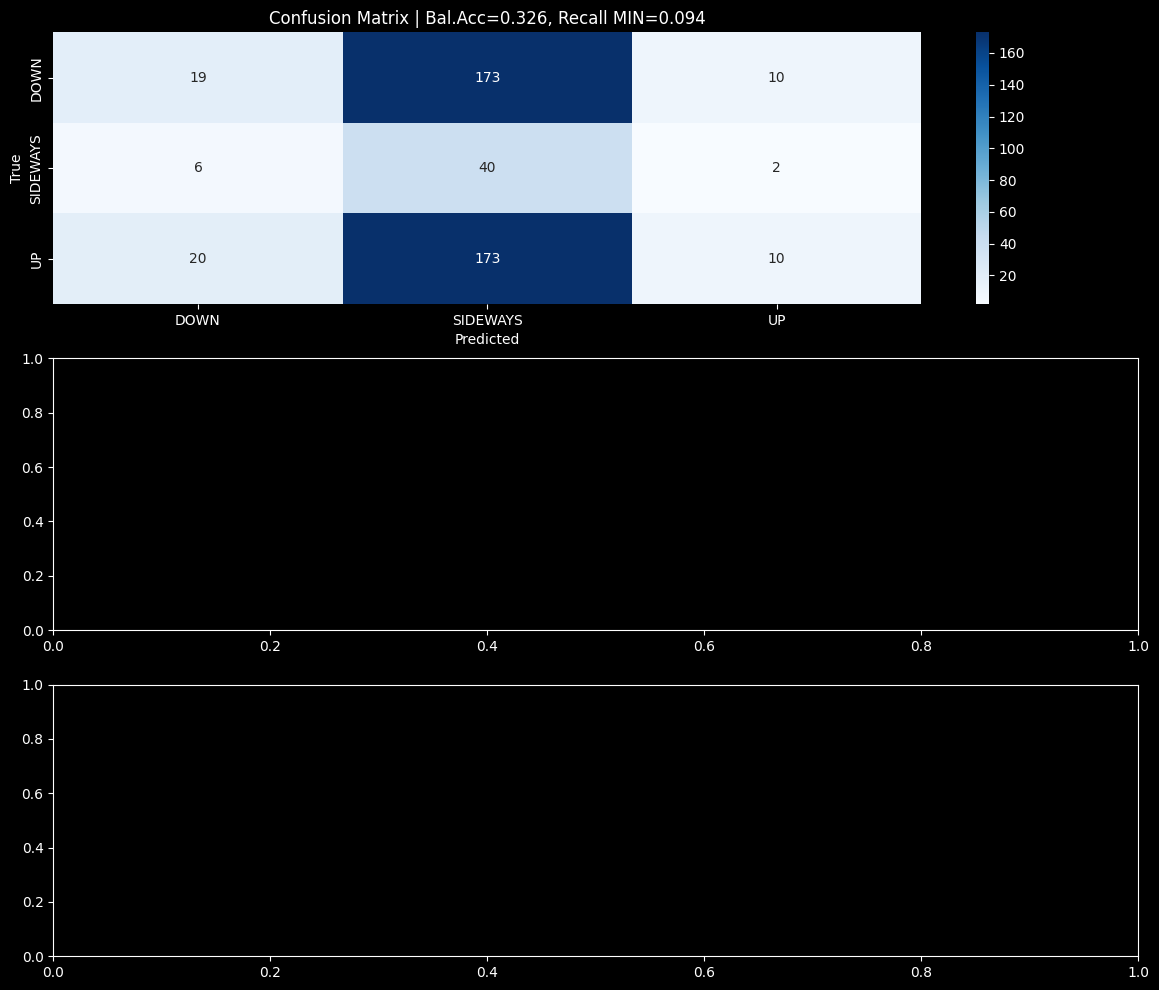

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════════
# FINAL EVALUATION OF BEST MODEL
# ═══════════════════════════════════════════════════════════════════════════════════
# Run the best configuration with full visualization
# ═══════════════════════════════════════════════════════════════════════════════════

if not df_results.empty:
    print("\n" + "=" * 80)
    print("TRAINING BEST MODEL FOR FULL EVALUATION...")
    print("=" * 80)
    
    best = df_results.iloc[0]
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best label params
    # ─────────────────────────────────────────────────────────────────────────────
    best_label_params = {
        "horizon": int(best["horizon"]),
        "gauss_window": int(best["gauss_window"]),
        "gauss_std": float(best.get("gauss_std", 50.0)),
    }
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best feature params
    # ─────────────────────────────────────────────────────────────────────────────
    best_feature_params = {
        "coord_mode": best["coord_mode"],
        "orb_multiplier": float(best["orb_multiplier"]),
        "include_phases": True,
    }
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Get best model params
    # ─────────────────────────────────────────────────────────────────────────────
    best_model_params = {
        "max_depth": int(best["max_depth"]),
        "learning_rate": float(best["learning_rate"]),
        "n_estimators": int(best.get("n_estimators", 500)),
        "weight_power": float(best["weight_power"]),
    }
    
    print(f"\nBest Label Params: {best_label_params}")
    print(f"Best Feature Params: {best_feature_params}")
    print(f"Best Model Params: {best_model_params}")
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Rebuild dataset with best params
    # ─────────────────────────────────────────────────────────────────────────────
    df_labels_best = get_or_compute_labels(df_market, best_label_params)
    df_features_best = get_or_compute_features(df_market, settings, best_feature_params)
    df_dataset_best = merge_features_with_labels(df_features_best, df_labels_best)
    
    # ─────────────────────────────────────────────────────────────────────────────
    # Train and evaluate with visualization
    # ─────────────────────────────────────────────────────────────────────────────
    final_metrics, final_model = train_and_evaluate_full(
        df_dataset_best,
        best_model_params.copy(),
        device,
        title=f"BEST MODEL (bal_acc={best['bal_acc']:.3f})"
    )
    
    print("\n✓ Best model evaluation complete!")
else:
    print("⚠️ No grid search results to evaluate")
